In [1]:
from sklearn.datasets import fetch_openml # load MNIST data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math # for exp in sigmoid

# 1. Load MNIST Dataset
<img src='media/MNIST_examples.png' alt='MNIST examples'>

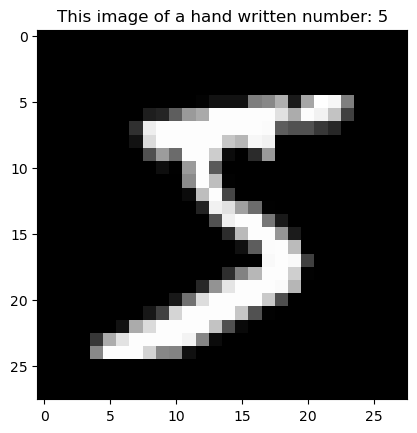

In [62]:
# load data from sklearn
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target'] # two dataframes
y_one_hot_array = pd.get_dummies(y, prefix='class').to_numpy().astype(int)
# plot first example
image = X.iloc[0].values.reshape(28, 28)
label = y.iloc[0]
plt.title(f'This image of a hand written number: {label}')
plt.imshow(image, cmap='gray')

# 2. Activation Functions

In [19]:
def ReLU(x):
    # rectified linear unit
    return np.maximum(0, x)

def SELU(x):
    # scaled exponential linear unit
    return np.where(x <= 0, 1.75809 * (np.exp(x)-1), 1.0507 * x)

def tanh(x):
    # hyperbolic tangent
    x = np.clip(x, -500, 500)  # prevent overflow
    exp_x = np.exp(x)
    exp_neg_x = np.exp(-x)
    return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)


def softmax(x):
    denominator = np.sum(np.exp(x)) # sum of all the e^logit for every logit
    return np.exp(x) / denominator # normalize e^logit value by sum of e^logits


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# 3. Initialize Numpy Neural Network
<img src='media/nn_arcitecture.png' alt='Network Arcitecture'>

## Weight Initializations

In [4]:
def xavier_init(size):
    in_dim, out_dim = size
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, size)


def he_init(size):
    in_dim, _ = size
    stddev = np.sqrt(2 / in_dim)
    return np.random.normal(0, stddev, size)

In [5]:
X.iloc[0].values.shape

(784,)

In [36]:
x = X.iloc[0].values / 255 # normalize it
input_size = X.iloc[0].values.shape[0]
output_size = len(y.values.unique())

#### Initialize weight matrixes

# first layer of model
l1_num_nodes = 1568
l1_weights = np.random.randn(input_size, l1_num_nodes)
l1_output = np.dot(x, l1_weights) # you would just add a bias term to this
print(f'shape of layer 1 rep: {l1_output.shape}')
# second layer of the model
l2_num_nodes = 2000
l2_weights = np.random.randn(l1_num_nodes, l2_num_nodes)
l2_output = np.dot(l1_output, l2_weights) # you would just add a bias term to this
print(f'shape of layer 2 rep: {l2_output.shape}')

# Third layer
l3_num_nodes = 784
l3_weights = np.random.randn(l2_num_nodes, l3_num_nodes)
l3_output = np.dot(l2_output, l3_weights) # you would just add a bias term to this
print(f'shape of layer 3 rep: {l3_output.shape}')

# Final output layer
l4_num_nodes = output_size
l4_weights = np.random.randn(l3_num_nodes, l4_num_nodes)
l4_output = np.dot(l3_output, l4_weights) # you would just add a bias term to this
print(f'output shape: {l4_output.shape}')

shape of layer 1 rep: (1568,)
shape of layer 2 rep: (2000,)
shape of layer 3 rep: (784,)
output shape: (10,)


In [183]:
from linearnn import linearnnclasses
linearlayer = linearnnclasses.LinearLayer(
    input_size=784, 
    output_size=1568, 
    activation_fn_class=ReLU, 
    weight_init=he_init
)

print(linearlayer)
linearlayer.forward(x)

LinearLayer input:784, output:1568, activation:<class 'linearnn.activationfunctions.ReLU'>


array([0.75272997, 0.69611051, 0.30338067, ..., 0.        , 0.        ,
       0.        ])

In [125]:
ReLU().forward([-10, 6])

array([0, 6])

In [144]:
x_batch = X.iloc[0:100].values / 255
print(x_batch.shape)

(100, 784)


In [262]:
from linearnn import linearnnclasses
from linearnn.activationfunctions import ReLU, SELU, Tanh, Softmax
# from linearnn.optim import AdamOptimizer
from linearnn import optim
import importlib
importlib.reload(linearnnclasses)
importlib.reload(optim)

class CategoricalCrossEntropy:
    def forward(self, y:np.array, y_hat:np.array):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15) # There should be no zeros but if there will that would cause a bug
        batch_size = y.shape[0]
        return -np.sum(y * np.log(y_hat)) / batch_size
    
    def derivative(self, y:np.array, y_hat:np.array):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        batch_size = y.shape[0]
        return -(y / y_hat) / batch_size



sequential_model = linearnnclasses.SequentialModel(
    input_size=784,
    output_size=10,
    hidden_layers=(1568, 784), 
    activation_fn_classes=(ReLU, SELU, ReLU, Softmax),
    weight_init=(he_init, he_init, he_init, he_init),
    loss_fn_class = CategoricalCrossEntropy,
    optimizer=None#optim.AdamOptimizer # with default settings (see linearnn/optim.py)
)
sequential_model.forward(x_batch)
sequential_model.backward(x_batch, y_one_hot_array[0:100, :])

building model...
Adding: LinearLayer input:784, output:1568, activation:<class 'linearnn.activationfunctions.SELU'>
Adding: LinearLayer input:1568, output:784, activation:<class 'linearnn.activationfunctions.ReLU'>
Adding: LinearLayer input:784, output:10, activation:<class 'linearnn.activationfunctions.Softmax'>
model built


7.0129398242600045

# 4. Model Training

In [263]:
num_epochs = 50
batch_size = 100

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    for i in range(0, X.iloc[0:60000].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]
        # print(np.unique(x_batch))
        loss = sequential_model.backward(x_batch, y_batch) # forward pass is incorperated in backward function
        # print(x_batch.shape)
        # print(y_batch.shape)
        print(loss)
        if loss == np.nan: print(1/0)
        # break
        running_loss += loss
    # break

    print(running_loss/(X.shape[0]/batch_size))


7.292762465215206
7.314172449721973
7.129204141841925
7.148207841704977
7.128680245987088
7.152731195564415
7.1472311280660366
7.22489715045167
7.206244743507414
7.09306089941958
7.144879556839974
7.1130051053909815
7.388344643083676
7.077581667837615
7.099552577768813
7.103527880421407
7.116570642259125
7.114268146538884
7.093622193912385
7.219028239463915
7.294398812233866
7.178690199835334
7.109915178218196
7.208174552923054
7.177926353417172
7.195112668629238
7.118757767345551
7.193112470210646
7.1331989563323885
7.163177274217185
7.118299904064668
7.24977598165777
7.1122541974183555
7.1519954911735155
7.128383522933937
7.10583277487387
7.150763298760633
7.110909920838911
7.140160857236701
7.130824779804532
7.105591796925299
7.17516111693398
7.1978415645341265
6.972018397563418
7.056152015349506
7.133973906549702
7.194210586582451
7.2382292439898155
7.151886470916285
6.993398117685756
7.1281455388152475
7.059622908124186
7.056767292819064
7.049793065249981
7.145765957842015
6.93778

KeyboardInterrupt: 

In [203]:
X[-100:-1].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [215]:
preds = sequential_model.forward(X[-100:-1].values)

In [216]:
max_indices = np.argmax(preds, axis=1)
max_indices

array([7, 7, 7, 7, 7, 1, 9, 4, 2, 5, 7, 7, 1, 7, 7, 7, 7, 6, 1, 9, 7, 8,
       7, 7, 6, 7, 7, 2, 6, 7, 6, 9, 2, 1, 6, 9, 7, 1, 7, 7, 1, 5, 8, 8,
       9, 0, 9, 7, 9, 6, 7, 1, 8, 7, 9, 1, 9, 5, 2, 9, 5, 9, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 6, 5, 7, 7, 9, 7, 9, 7, 7, 9, 9, 0, 7, 9, 1, 7,
       7, 7, 7, 8, 7, 7, 7, 2, 1, 1, 1], dtype=int64)

In [217]:
np.argmax(y_one_hot_array[-100:-1, :], axis=1)

array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5], dtype=int64)